### Below dataloader has a problm: 
1. You have to know the number of data in each files. 
2. You have to have files of same number of snapshots. 
3. I think it would be better to treat each of those files as one datapoints.

In [ ]:
import os
import logging
from netCDF4 import Dataset
from torch.utils.data import Dataset as TorchDataset
import torch

class NCDataset(TorchDataset):
    def __init__(self, input_directory, output_directory, variable_names, data_per_file):
        """
        :param input_directory: Directory where the input .nc files are stored.
        :param output_directory: Directory where the output .nc files are stored.
        :param variable_names: Dictionary with keys 'input' and 'output', and values as lists of variable names.
        :param data_per_file: Number of data points in each .nc file.
        """
        self.input_directory = input_directory
        self.output_directory = output_directory
        self.variable_names = variable_names
        self.data_per_file = data_per_file
        self.files = self._load_files()

    @staticmethod
    def load_nc_files(directory, variable_name, file_index):
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]
        if not files:
            logging.error("No .nc files found in the directory.")
            return None

        files.sort(key=lambda x: int(x.split('.')[0]))
        if file_index < 0 or file_index >= len(files):
            logging.error("file_index is out of range.")
            return None

        file_path = os.path.join(directory, files[file_index])
        try:
            with Dataset(file_path, 'r') as nc_file:
                if variable_name not in nc_file.variables:
                    logging.error(f"Variable {variable_name} not found in the file.")
                    return None
                data = nc_file.variables[variable_name][:]
        except Exception as e:
            logging.error(f"Error reading the .nc file: {str(e)}")
            return None

        return data

    def _load_files(self):
        files = os.listdir(self.input_directory)
        files = [f for f in files if f.endswith('.nc')]
        files.sort(key=lambda x: int(x.split('.')[0]))
        return files

    def __len__(self):
        return len(self.files) * self.data_per_file

    def __getitem__(self, idx):
        file_idx, data_idx = divmod(idx, self.data_per_file)
        inputs = [self.load_nc_files(self.input_directory, var, file_idx) for var in self.variable_names['input']]
        outputs = [self.load_nc_files(self.output_directory, var, file_idx) for var in self.variable_names['output']]
        inputs = [data[data_idx] for data in inputs]
        outputs = [data[data_idx] for data in outputs]

        input_tensor = torch.stack(inputs, dim=0)
        output_tensor = torch.stack(outputs, dim=0)

        return input_tensor, output_tensor


In [1]:
import os
import logging
from netCDF4 import Dataset
from torch.utils.data import Dataset as TorchDataset
import torch


class NCDataset(TorchDataset):
    """
    Dataset for loading NetCDF files.
    """
    def __init__(self, input_directory: str, output_directory: str, variable_names: dict):
        """
        :param input_directory: Directory where the input .nc files are stored.
        :param output_directory: Directory where the output .nc files are stored.
        :param variable_names: Dictionary of variable names to load from the .nc files. Should have 'input' and 'output' keys.
        """
        self.input_directory = input_directory
        self.output_directory = output_directory
        self.variable_names = variable_names
        self.input_files = self._load_files(input_directory)
        self.output_files = self._load_files(output_directory)

    @staticmethod
    def load_nc_files(directory: str, variable_name: str, file_index: int):
        """
        Load data from a .nc file.

        :param directory: Directory where the .nc files are stored.
        :param variable_name: Name of the variable to load from the .nc files.
        :param file_index: Index of the file to load.
        :return: Data loaded from the .nc file, or None if an error occurred.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]

        if not files:
            logging.error("No .nc files found in the directory.")
            return None

        files.sort(key=lambda x: int(x.split('.')[0]))

        if file_index < 0 or file_index >= len(files):
            logging.error("file_index is out of range.")
            return None

        file_path = os.path.join(directory, files[file_index])

        try:
            with Dataset(file_path, 'r') as nc_file:
                if variable_name not in nc_file.variables:
                    logging.error(f"Variable {variable_name} not found in the file.")
                    return None

                data = nc_file.variables[variable_name][:]
        except Exception as e:
            logging.error(f"Error reading the .nc file: {str(e)}")
            return None

        return data

    def _load_files(self, directory):
        """
        Load the list of .nc files from the directory.

        :return: Sorted list of .nc files in the directory.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]
        files.sort(key=lambda x: int(x.split('.')[0]))
        return files

    def __len__(self):
        """
        Get the total number of datapoints across all .nc files in the directory.

        :return: Total number of datapoints across all .nc files.
        """
        return len(self.files) * self.data_per_file

    
    def __getitem__(self, idx: int):
        """
        Get the data from the .nc file at the given index.

        :param idx: Index of the .nc file to load.
        :return: Tuple of input and output data from the .nc file as torch.Tensors.
        """
        file_idx, data_idx = divmod(idx, self.data_per_file)

        inputs = [self.load_nc_files(self.input_directory, var, file_idx) for var in self.variable_names['input']]
        outputs = [self.load_nc_files(self.output_directory, var, file_idx) for var in self.variable_names['output']]

        inputs = [data[data_idx] for data in inputs]
        outputs = [data[data_idx] for data in outputs]

        input_tensor = torch.cat(inputs, dim=0)
        output_tensor = torch.cat(outputs, dim=0)

        return input_tensor, output_tensor



/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import os
import logging
from netCDF4 import Dataset
from torch.utils.data import Dataset as TorchDataset
import torch


class NCDataset(TorchDataset):
    """
    Dataset for loading NetCDF files.
    """
    def __init__(self, input_directory: str, output_directory: str, variable_names: dict):
        """
        :param input_directory: Directory where the input .nc files are stored.
        :param output_directory: Directory where the output .nc files are stored.
        :param variable_names: Dictionary of variable names to load from the .nc files. Should have 'input' and 'output' keys.
        """
        self.input_directory = input_directory
        self.output_directory = output_directory
        self.variable_names = variable_names
        self.input_files = self._load_files(input_directory)
        self.output_files = self._load_files(output_directory)

    @staticmethod
    def load_nc_files(directory: str, variable_name: str, file_index: int):
        """
        Load data from a .nc file.

        :param directory: Directory where the .nc files are stored.
        :param variable_name: Name of the variable to load from the .nc files.
        :param file_index: Index of the file to load.
        :return: Data loaded from the .nc file, or None if an error occurred.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]

        if not files:
            logging.error("No .nc files found in the directory.")
            return None

        files.sort(key=lambda x: int(x.split('.')[0]))

        if file_index < 0 or file_index >= len(files):
            logging.error("file_index is out of range.")
            return None

        file_path = os.path.join(directory, files[file_index])

        try:
            with Dataset(file_path, 'r') as nc_file:
                if variable_name not in nc_file.variables:
                    logging.error(f"Variable {variable_name} not found in the file.")
                    return None

                data = nc_file.variables[variable_name][:]
        except Exception as e:
            logging.error(f"Error reading the .nc file: {str(e)}")
            return None

        return data

    def _load_files(self, directory):
        """
        Load the list of .nc files from the directory.

        :return: Sorted list of .nc files in the directory.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]
        files.sort(key=lambda x: int(x.split('.')[0]))
        return files

    def __len__(self):
        """
        Get the number of .nc files in the directory.

        :return: Number of .nc files in the directory.
        """
        return len(self.input_files)
    
    def __getitem__(self, idx: int):
        """
        Get the data from the .nc file at the given index.

        :param idx: Index of the .nc file to load.
        :return: Tuple of input and output data from the .nc file as torch.Tensors.
        """
        inputs = [self.load_nc_files(self.input_directory, var, idx) for var in self.variable_names['input']]
        outputs = [self.load_nc_files(self.output_directory, var, idx) for var in self.variable_names['output']]
        
        # if loading was unsuccessful, return None
        if any(v is None for v in inputs+outputs):
            return None

        inputs = torch.cat([torch.from_numpy(data) for data in inputs], dim=1)
        outputs = torch.cat([torch.from_numpy(data) for data in outputs], dim=1)

        return inputs, outputs


/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# --------------------------- Importing Libraries ---------------------------
print("--------------------------- Importing Libraries ---------------------------")
from ray.air import session
from torch.utils.data import DataLoader, Subset
from scipy.io import savemat
from utils.utils import MyDataset, plot_loss
from utils.corr2 import corr2
from utils.count_parameters import count_parameters
from utils.cc_energy_transfer_2d_fhit import cc_energy_transfer_2d_fhit
from utils.comparison_contour_plot import comparison_contour_plot
from utils.create_contour_plot import create_contour_plot
from utils.post_proccess import post_proccess
from prettytable import PrettyTable
import sys
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import json


--------------------------- Importing Libraries ---------------------------


In [6]:
# --------------------------- CNN Architecture ---------------------------
print("--------------------------- Setting CNN Architecture ---------------------------")
#Creating a CNN class
class ConvNeuralNet(nn.Module):

        # Determine what layers and their order in CNN object
        def __init__(self, num_classes):

                super(ConvNeuralNet, self).__init__()

                self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                self.conv_layer11 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=5, padding="same")
                self.relu1 = nn.ReLU()
                
        def forward(self, x):

                out = self.conv_layer1(x) # Layer1 (Input Layer)
                out = self.relu1(out)

                ## Hidden Layers
                out = self.conv_layer2(out) #Layer2
                out = self.relu1(out)

                out = self.conv_layer3(out) #Layer3
                out = self.relu1(out)

                out = self.conv_layer4(out) #Layer4
                out = self.relu1(out)

                out = self.conv_layer5(out) #Layer5
                out = self.relu1(out)

                out = self.conv_layer6(out) #Layer6
                out = self.relu1(out)

                out = self.conv_layer7(out) #Layer7
                out = self.relu1(out)

                out = self.conv_layer8(out) #Layer8
                out = self.relu1(out)

                out = self.conv_layer9(out) #Layer9
                out = self.relu1(out)

                out = self.conv_layer10(out) #Layer10
                out = self.relu1(out)

                out = self.conv_layer11(out) #Layer11 (Output Layer)
                return out


--------------------------- Setting CNN Architecture ---------------------------


In [7]:
# --------------------------- Setting up Hyper-Parmeters for CNN ---------------------------
print("--------------------------- Setting up Hyper-Parmeters for CNN ---------------------------")
#Define relevant parameters for Training
config_default = {
          "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
          "batch_size_train": 8, 
          "learning_rate": 5e-5,
          "num_classes": 1,
          "num_epochs": 100,
          "p_data":2000, # Number of data to be trained 
         }

config = config_default

--------------------------- Setting up Hyper-Parmeters for CNN ---------------------------


--------------------------- Training Initialization ---------------------------
**** Number of Trainable Parameters in BNN ****
+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|  conv_layer1.weight |    6400    |
|   conv_layer1.bias  |     64     |
|  conv_layer2.weight |   102400   |
|   conv_layer2.bias  |     64     |
|  conv_layer3.weight |   102400   |
|   conv_layer3.bias  |     64     |
|  conv_layer4.weight |   102400   |
|   conv_layer4.bias  |     64     |
|  conv_layer5.weight |   102400   |
|   conv_layer5.bias  |     64     |
|  conv_layer6.weight |   102400   |
|   conv_layer6.bias  |     64     |
|  conv_layer7.weight |   102400   |
|   conv_layer7.bias  |     64     |
|  conv_layer8.weight |   102400   |
|   conv_layer8.bias  |     64     |
|  conv_layer9.weight |   102400   |
|   conv_layer9.bias  |     64     |
| conv_layer10.weight |   102400   |
|  conv_layer10.bias  |     64     |
| conv_layer11.weight

In [9]:
def train_model(config=config_default):
    # --------------------------- Initialization ---------------------------
    print("--------------------------- Training Initialization ---------------------------")

    # 0. Model Initialization
    model = ConvNeuralNet(config["num_classes"]).to(config["device"])

    print('**** Number of Trainable Parameters in BNN ****')
    count_parameters(model)

    # 0.1. Set loss funtion with criterion
    criterion = nn.MSELoss()

    # 0.2 Set the optimizer (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr= config['learning_rate'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad = True)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-9, last_epoch=- 1, verbose=True)
    
    # --------------------------- Loading DATA ---------------------------
    print("--------------------------- Loading DATA ---------------------------")

    # 1. Loading the base model (Optional)[For Transfer Learning purpose]
    '''    
    print("---Loading Base model---")
    base_model_path = '/home/exouser/tl/10layer/base_model.pt' # PATH
    base_model = torch.load(base_model_path) # Loading Model
    model.load_state_dict(base_model['model_state_dict']) # Loading model State_dict
    #optimizer.load_state_dict(base_model['optimizer_state_dict']) # Optimizer Loading
    '''

    # 2. Loading Data
    # 2.1 Loading training data set
    x_train_path = '/media/volume/sdc/data_qg/3jet/'
    y_train_path = '/media/volume/sdc/data_qg/3jet/'

    # Create a dataset
    nc_dataset = NCDataset(input_directory=x_train_path, 
                        output_directory=y_train_path, 
                        variable_names={'input': ['u', 'v'], 'output': ['q']})

    # Splitting the data to train and test
    train_size = int(0.8 * len(nc_dataset))
    test_size = len(nc_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(nc_dataset, [train_size, test_size])

    # Use the dataset with a DataLoader
    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
        
    # --------------------------- Training Part ---------------------------
    loss_epoch = []
    loss_test_epoch = []
    cc_epoch = []
    weights = []
    best_test_loss = float('inf')
    print("--------------------------- Training Part ---------------------------")

    # 3. Training Loop
    table = PrettyTable(['Epoch', 'Total Epoch', 'Training Loss', 'Test Loss', 'CC_tau11', 'CC_tau12', 'CC_tau22'])
    table.align = 'r'
    # print('Epoch  TotalEpoch    Training Loss   Test Loss   CC_tau11    CC_tau12    CC_tau22 \n ---------------------------------------------------------------------------------')
    for epoch in range(config['num_epochs']):
    
    # Load the data from train and test dataloader

        # Training Data Loop
        for data_train in data_loader_train:

            # Get batch of data
            inputs_train, labels_train = data_train[0].reshape(-1, 4, 64, 64), data_train[1].reshape(-1, 2, 64, 64)
        
            # Move tensors to the configured device with right data type
            inputs_train = inputs_train.to(device=config['device'], dtype = torch.float32)
            labels_train = labels_train.to(device=config['device'], dtype = torch.float32)

            # Forward pass train 
            model_output = model(inputs_train)
            loss = criterion(model_output, labels_train)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        
        for data_test in data_loader_test:
            
            #Get batch of data
            inputs_test, labels_test = data_test[0].reshape(-1, 4, 64, 64), data_test[1].reshape(-1, 2, 64, 64)
            
            # Move tensors to the configured device
            inputs_test = inputs_test.to(device=config['device'], dtype = torch.float32)
            labels_test = labels_test.to(device=config['device'], dtype = torch.float32)

            # Evaluating test loss
            model_output_test = model(inputs_test)
            loss_test = criterion(model_output_test, labels_test)
            
        # ccs_test = post_proccess(inputs_test[:,0].cpu().detach(), inputs_test[:,1].cpu().detach(), labels_test[:,0].cpu().detach(), labels_test[:,1].cpu().detach(), labels_test[:,2].cpu().detach(), model_output_test[:,0].cpu().detach(), model_output_test[:,1].cpu().detach(), model_output_test[:,2].cpu().detach())
            

        # # Saving Model Checkpoint
        # if (epoch + 1 ) % 100 == 0:
            
        #     # Save the model checkpoint XXXX
        #     modelname = "checkpoint_epoch" + str(epoch+1) + ".pt"
        #     torch.save({
        #                 'model_state_dict': model.state_dict(),
        #                 'epoch' : epoch,
        #                 'optimizer_state_dict' : optimizer.state_dict(),
        #                 'loss' : loss,
        #                 'loss_test' : loss_test,
        #                 },modelname)
        #     print("Checkpoint {} has been saved!".format(epoch+1))
            
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            # Save the model checkpoint XXXX
            modelname = "best_model.pt"
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'epoch' : epoch,
                        'optimizer_state_dict' : optimizer.state_dict(),
                        'loss' : loss,
                        'loss_test' : loss_test,
                        },modelname)
            print("Checkpoint {} has been saved as the BEST model so far!".format(epoch+1))

        # Storing Loss, loss_test, cc histroy
        loss_epoch.append(loss.item())
        loss_test_epoch.append(loss_test.item())
        print(f"Epoch[{epoch+1}/{config['num_epochs']}] TrainingLoss:{loss.item():10.3e} TestLoss:{loss_test.item():10.3e}")
        # print(f"{epoch+1:6d}\t{config['num_epochs']:6d}\t\t{loss.item():10.3e}\t{loss_test.item():10.3e}\t{cc[0]:6.4f}\t{cc[0]:6.4f}\t{cc[0]:6.4f}")
        # table.add_row([epoch+1, config['num_epochs'], f"{loss.item():10.3e}", f"{loss_test.item():10.3e}", f"{cc[0]:6.4f}", f"{cc[1]:6.4f}", f"{cc[2]:6.4f}"])
        # scheduler.step()
    # End of Epoch 
    # print(table)

    # Saving weights for the training
    for i in range(11):
        layer_name = "conv_layer" + str(i+1)
        weights.append(getattr(model,layer_name).weight.data.cpu().numpy())

    # # Save final model
    # modelname = "model.pt"
    # torch.save({
    #             'model_state_dict': model.state_dict(),
    #             'epoch' : epoch,
    #             'optimizer_state_dict' : optimizer.state_dict(),
    #             'loss' : loss,
    #             'loss_test' : loss_test,
    #             },modelname)

    # print('Trained model has been saved successfully!')

    # --------------------------- Inference Part ---------------------------
    print("--------------------------- Inference Part ---------------------------")

    '''
    # This is just for the evaluation (Optional)
    base_model_path = 'model.pt' # PATH
    base_model = torch.load(base_model_path) # Loading Model
    model.load_state_dict(base_model['model_state_dict']) # Loading model State_dict
    #optimizer.load_state_dict(base_model['optimizer_state_dict']) # Optimizer Loading
    ## Free up memory
    #del inputs_train, labels_train
    #torch.cuda.empty_cache()
    '''
    data_loader_test = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialzing the inference Initializng the
    prediction = torch.tensor([], dtype = torch.float32)
    true = torch.tensor([], dtype = torch.float32)
    inputs = torch.tensor([], dtype = torch.float32)
    best_model_path = 'best_model.pt' # PATH
    best_model = torch.load(best_model_path) # Loading Model
    model.load_state_dict(best_model['model_state_dict']) # Loading model State_dict
    


    # denormalize_input = transforms.Normalize(mean=[-m/s for m, s in zip(input_mean, input_std)], std=[1/s for s in input_std])
    # denormalize_output = transforms.Normalize(mean=[-m/s for m, s in zip(output_mean, output_std)], std=[1/s for s in output_std])

    #denormalize_output = transforms.Normalize(mean=[-m/s for m, s in zip(output_mean.tolist(), output_std.tolist())], std=[1/s for s in output_std.tolist()])
    #denormalize_output = transforms.Normalize(mean=[-output_mean/output_std], std=[1/output_std])

    # # Test Loop
    # for data_test in data_loader_test:

    #     # Get batches of test data set
    #     inputs_test, label_test = data_test
    #     # Move tensors to the configured device
    #     inputs_test = inputs_test.to(device=config['device'], dtype = torch.float32)

    #     # Evaluating test loss
    #     model_output_test = model(inputs_test)

    #     # Denormalizing Test data [input and output]
    #     inputs_test_normalized = denormalize_input(inputs_test)
    #     label_test_normalized = denormalize_output(label_test)
    #     model_output_test_normalized = denormalize_output(model_output_test) 

    #     # Detach from GPU 
    #     model_output_test_normalized = model_output_test_normalized.detach().cpu()
    #     inputs_test_normalized = inputs_test_normalized.detach().cpu()

    #     # Store 
    #     inputs = torch.cat([inputs, inputs_test_normalized])
    #     prediction = torch.cat([prediction, model_output_test_normalized])
    #     true = torch.cat([true, label_test_normalized])

    # --------------------------- Saving the outputs  --------------------------- 
    print("--------------------------- Saving the outputs ---------------------------")

    # ccs = post_proccess(inputs[:,0], inputs[:,1], true[:,0], true[:,1], true[:,2], prediction[:,0], prediction[:,1], prediction[:,2])

    plot_loss(loss_epoch, loss_test_epoch, save_fig=True, fig_name='loss.pdf')

    # # Dumping the output to txt file
    # file_name = 'metrics_lr' + str(config['learning_rate']) + '_bs' + str(config['batch_size_train']) + '.txt'
    # with open(file_name, "w") as f:
    #     json.dump(ccs, f)

    # ## Saving the output data to .mat file
    # output = {
    #             "Tau_model":prediction.numpy(), 
    #             "Tau_FDNS":true.numpy(),
    #             "UV": inputs.numpy(),
    #             "weights":weights,
    #             "train_loss":loss_epoch,
    #             "test_loss":loss_test_epoch,
    #             "ccs": ccs,
    #             }

    # filename = "Data.mat"
    # savemat(filename, output)
    # metric =  session.report({"metric": loss_epoch[-1]})  # Send the score to Tune.  
    # # metric =  session.report({"metric": cc_epoch[-1]})  # Send the score to Tune.  

    print("--------------------------- Model has been trained succesfully! ---------------------------")
    # return metric

--------------------------- Loading DATA ---------------------------
--------------------------- Training Part ---------------------------
Checkpoint 1 has been saved as the BEST model so far!
Epoch[1/100] TrainingLoss: 2.178e-05 TestLoss: 8.482e-06
Checkpoint 2 has been saved as the BEST model so far!
Epoch[2/100] TrainingLoss: 8.482e-06 TestLoss: 2.602e-06
Epoch[3/100] TrainingLoss: 2.602e-06 TestLoss: 2.607e-06
Epoch[4/100] TrainingLoss: 2.606e-06 TestLoss: 4.915e-06
Epoch[5/100] TrainingLoss: 4.913e-06 TestLoss: 6.311e-06
Epoch[6/100] TrainingLoss: 6.310e-06 TestLoss: 6.090e-06
Epoch[7/100] TrainingLoss: 6.089e-06 TestLoss: 4.880e-06
Epoch[8/100] TrainingLoss: 4.879e-06 TestLoss: 3.501e-06
Checkpoint 9 has been saved as the BEST model so far!
Epoch[9/100] TrainingLoss: 3.500e-06 TestLoss: 2.472e-06
Checkpoint 10 has been saved as the BEST model so far!
Epoch[10/100] TrainingLoss: 2.471e-06 TestLoss: 1.942e-06
Checkpoint 11 has been saved as the BEST model so far!
Epoch[11/100] Trai

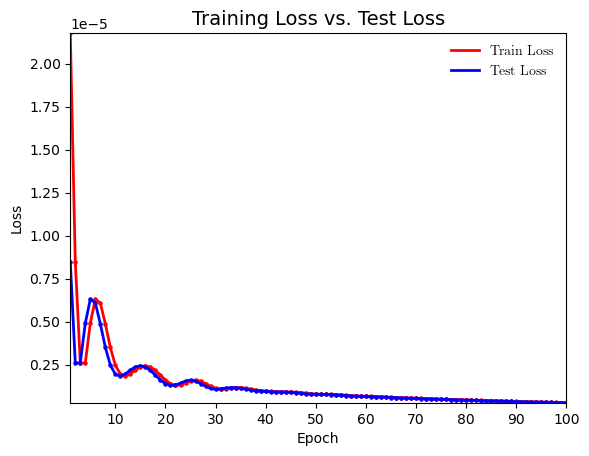

--------------------------- Model has been trained succesfully! ---------------------------
